This notebook implements Implicit Q-Learning to solve a simple Maze 2D environment.

In [32]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
from torch.optim.lr_scheduler import CosineAnnealingLR

from typing import Tuple, Optional

import numpy as np
from loguru import logger
import matplotlib.pyplot as plt
from IPython.display import Image
from src.utils import (
    get_device,
    set_seed,
    eval_policy,
    demo_policy,
    plot_returns,
    save_frames_as_gif,
    return_range
)
from tqdm import tqdm
import einops
import os
import copy

from src.d4rl_dataset import D4RLSampler

plt.ion()

Offline RL algorithms aim at training an optimal policy from pre-collected data. As such, we need to import this training data that will be used with IQL.
For that purpose, we start by importing D4RL, a library that contains training data obtained by running policy of different levels on a few environments. More information about D4RL can be found [in the original paper.](https://arxiv.org/abs/2004.07219).

In [33]:
import gym
import d4rl

Then, we create the environment. As an example, we use the Maze2D U-shaped environment, for which the objective is to move a ball to explore a maze using two forces, lateral and longitudinal. The action space is continuous and has dimension 2. For reproducibility, we also set the seed to a fixed value.

In [34]:
SEED: int = 42
ENVIRONMENT_NAME: str='hopper-medium-replay-v2'

# torch related defaults
DEVICE = get_device()
torch.set_default_dtype(torch.float32)

# Use random seeds for reproducibility
set_seed(SEED)

# instantiate the environment
env = gym.make(ENVIRONMENT_NAME)

# get the state and action dimensions
action_dimension = env.action_space.shape[0]
state_dimension = env.observation_space.shape[0]

logger.info(f'Action Dimension: {action_dimension}')
logger.info(f'Action High: {env.action_space.high}')
logger.info(f'Action Low: {env.action_space.low}')
logger.info(f'State Dimension: {state_dimension}')

2024-12-11 09:42:21.398 | INFO     | src.utils:get_device:52 - Using cuda device.
2024-12-11 09:42:21.407 | INFO     | src.utils:set_seed:38 - Random seed set as 42.
2024-12-11 09:42:21.412 | INFO     | __main__:<module>:18 - Action Dimension: 3
2024-12-11 09:42:21.413 | INFO     | __main__:<module>:19 - Action High: [1. 1. 1.]
2024-12-11 09:42:21.413 | INFO     | __main__:<module>:20 - Action Low: [-1. -1. -1.]
2024-12-11 09:42:21.414 | INFO     | __main__:<module>:21 - State Dimension: 11


Then, we need to download the training data for the Maze2D environment using D4RL library. For convenience, we create a sampler that returns the training data in batches of size 256, which will be used during the training (this function was borrowed from HW2 for convenience).

In [35]:
dataset = d4rl.qlearning_dataset(env)

logger.info(f'Dataset type: {type(dataset)}')
logger.info(f'Dataset keys: {dataset.keys()}')
logger.info(f'# Samples: {len(dataset["observations"])}')
sampler = D4RLSampler(dataset, 256, DEVICE)

load datafile: 100%|██████████| 11/11 [00:00<00:00, 27.50it/s]
2024-12-11 09:42:23.385 | INFO     | __main__:<module>:3 - Dataset type: <class 'dict'>
2024-12-11 09:42:23.386 | INFO     | __main__:<module>:4 - Dataset keys: dict_keys(['observations', 'actions', 'next_observations', 'rewards', 'terminals'])
2024-12-11 09:42:23.387 | INFO     | __main__:<module>:5 - # Samples: 401598


As a Q-learning algorithm, IQL tries to fit a Q function to estimate the value of state-action pairs. Therefore, we need to define a Q-network that will be used to fix this function. In order to prevent overestimation of the state-action values, we use a double Q-network in this notebook, even though this is not something that is required in IQL (and it was not used in the original IQL paper). This network is defined below.

In [36]:
class QNetwork(nn.Module):
    def __init__(self, state_dimension, action_dimension, hidden_dim, n_hidden):
        super(QNetwork, self).__init__()

        # Q1 architecture
        self.Q1 = nn.Sequential(
            nn.Linear(state_dimension+action_dimension,hidden_dim),
            nn.ReLU(),
            *nn.ModuleList([nn.Linear(hidden_dim,hidden_dim),nn.ReLU()]*n_hidden),
            nn.Linear(hidden_dim,1)
        )
       
        # Q2 architecture
        self.Q2 = nn.Sequential(
            nn.Linear(state_dimension+action_dimension,hidden_dim),
            nn.ReLU(),
            *nn.ModuleList([nn.Linear(hidden_dim,hidden_dim),nn.ReLU()]*n_hidden),
            nn.Linear(hidden_dim,1)
        )


    def forward(self, state, action):
        xu = torch.cat([state, action], 1)
        q1 = self.Q1(xu)
        q2 = self.Q2(xu)
        return q1, q2
    
hidden_dim: int = 256
n_hidden: int = 2
lr: float = 3e-4

q_critic = QNetwork(state_dimension, action_dimension, hidden_dim, n_hidden).to(DEVICE)
q_critic_target = copy.deepcopy(q_critic)
q_critic_target.requires_grad_(False)
q_optimizer = Adam(q_critic.parameters(), lr)

As an offline algorithm, IQL tries to avoid querying unseen actions during training, as the value of such actions would be overestimated and could lead to a policy that operates in unknown territory. Therefore, IQL uses a SARSA-like objective to learn the Q function. The formal objective is:
$$
L(\theta) = \mathbb{E}_{(s, a, s') \sim \mathcal{D}} \left[ \left( r(s, a) + \gamma \max_{a' \in \mathcal{A}, \, \text{s.t.} \, \pi_\beta(a'|s') > 0} Q_{\hat{\theta}}(s', a') - Q_\theta(s, a) \right)^2 \right].
$$

To estimate the constrained maximum in this equation, the authors propose to fit a value function $V(s)$, which estimates the value of a state *for the actions present in the training data only.* The neural network used to fit this value function is defined below.

In [37]:
class VNetwork(nn.Module):
    def __init__(self, state_dimension, hidden_dim, n_hidden):
        super(VNetwork, self).__init__()

        self.V = nn.Sequential(
            nn.Linear(state_dimension,hidden_dim),
            nn.ReLU(),
            *nn.ModuleList([nn.Linear(hidden_dim,hidden_dim),nn.ReLU()]*n_hidden),
            nn.Linear(hidden_dim,1)
        )
        
    def forward(self, state):
        v = self.V(state)
        return v
    

v_critic = VNetwork(state_dimension, hidden_dim, n_hidden).to(DEVICE)
v_optimizer = Adam(v_critic.parameters(), lr)

In order to estimate the state value of a state based on the observed actions and rewards in the training data, IQL uses expectile regression. The idea is that in the training data, the different actions taken from a state induced a distribution of observed future rewards. When the MSE loss would fit the mean of this distribution, an asymmetrical expectile loss can be used to fit a higher quantile of that distribution, effectively estimating the maximum future (discounted) reward *for in-distribution actions*. This loss is defined as:

$$
L_\tau(u) =
\begin{cases}
\tau u^2 & \text{if } u \geq 0, \\
(1 - \tau) u^2 & \text{if } u < 0
\end{cases}
$$

The expectile loss function used to fit the value function $V(s)$ is defined below.

In [38]:
tau = 0.85

def expectile_loss(diff, expectile=0.8):
    return torch.abs(expectile-(diff<0).int())*torch.square(diff)

The fitted value function $V(s)$, we can then calculate the TD error and fit the Q-function without ever querying out-of-distribution actions. This is done by replacing the maximumin the TD error with the value function $V(s')$:

$$
L_Q(\theta) = \mathbb{E}_{(s, a, s') \sim \mathcal{D}} \left[ \left( r(s, a) + \gamma V_\psi(s') - Q_\theta(s, a) \right)^2 \right].
$$

This loss is defined below.

In [39]:
discount = 0.99

def Q_loss(target, q_critic):
    q_values = q_critic(state,action)
    q_loss = F.mse_loss(q_values[0], target) + F.mse_loss(q_values[1], target)
    return q_loss

Finally, we need to extract a policy from the fitted value functions. In traditional Q-learning, this is usually done by choosing the action that maximizes the Q-function at each step. However, to avoid querying *OOD* actions, IQL builds up on previous work and extract a policy using **advantage weighted regression**. This approach is similar to performing Maximum Likelihood Estimation for behavioral cloning, except that the actions are weighted based on their advantage value, calculated using the previously fitted value function. Therefore, the policy loss is defined as:

$$
L_\pi(\phi) = \mathbb{E}_{(s, a) \sim \mathcal{D}} \left[ \exp\left(\beta \left(Q_{\hat{\theta}}(s, a) - V_\psi(s)\right)\right) \log \pi_\phi(a | s) \right]
$$

In the next cell, we build a gaussian policy network, which will be trained using this loss function (defined below).

In [40]:
from torch.distributions.normal import Normal

DEVICE = get_device()
HIDDEN_DIMENSION: int = 256
N_HIDDEN: int = 2

def tensor(x: np.array, type=torch.float32, device=DEVICE) -> torch.Tensor:
    return torch.as_tensor(x, dtype=type, device=device)


def network(
        in_dimension: int, 
        out_dimension: int, 
        hidden_dimension: int = 256, 
        n_hidden: int = 3) -> nn.Module:
    """
    Args:
        in_dimension (int): Dimension of the input layer.
        hidden_dimension (int): Dimension of the hidden layers.
        out_dimension (int): Dimension of the output layer.

    Returns:
        nn.Module: The constructed neural network model.
    """
    shapes = [in_dimension] + [hidden_dimension] * n_hidden + [out_dimension]
    layers = []
    for i in range(len(shapes) - 2):
        layers.append(nn.Linear(shapes[i], shapes[i+1]))
        layers.append(nn.Mish())
    layers.append(nn.Linear(shapes[-2], shapes[-1]))
    return nn.Sequential(*layers)


class GaussianPolicy(nn.Module):
    def __init__(
            self,
            state_dimension: int,
            action_dimension: int,
            hidden_dimension: int = HIDDEN_DIMENSION,
            n_hidden: int = N_HIDDEN,
            action_space = None
    ):
        super(GaussianPolicy, self).__init__()
        self.network = network(
            state_dimension, 2 * action_dimension, hidden_dimension, n_hidden
        )
        self.action_dimension = action_dimension
      
        if action_space != None:
            self.action_scale = tensor((action_space.high-action_space.low)/2)
            self.action_bias = tensor((action_space.high+action_space.low)/2)

    def forward(self, state: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        """
        Forward pass of the Policy network. Should return mean and log_std of the policy distribution

        Args:
            state (np.ndarray): The input state.

        Returns:
            Tuple[torch.Tensor, torch.Tensor]: The tuple (mean, log_std) of the distribution corresponding to each action
        """
        out = self.network(state)
        mean, log_std = torch.split(out, self.action_dimension, dim=-1)
        log_std = torch.clamp(log_std, -10, 2)
        return mean, log_std
        

    def pi(self, state: torch.Tensor) -> Normal:
        """
        Computes the action distribution π(a|s) for a given state.

        Args:
            state (np.ndarray): The input state.

        Returns:
            Categorical: The action distribution.
        """
        mean, log_std = self(state)
        std = log_std.exp()
        return Normal(mean, std)

    def action(self, state: np.ndarray, eval=False) -> np.ndarray:
        """
        Selects an action based on the policy without returning the log probability.

        Args:
            state (np.ndarray): The input state.

        Returns:
            torch.Tensor: The selected action.
        """
        state = tensor(state)

        policy = self.pi(state)
        if eval:
            action = policy.mean.cpu().numpy()
        else:
            action = policy.sample().cpu().numpy()
        return action
    

iql_policy = GaussianPolicy(state_dimension, action_dimension, hidden_dim, n_hidden).to(DEVICE)
policy_optimizer = Adam(iql_policy.parameters(), lr)

2024-12-11 09:42:23.440 | INFO     | src.utils:get_device:52 - Using cuda device.


In [41]:
exp_advantage_max = 100
beta = 4 #inverse temperature parameter

def policy_loss(iql_policy, q_critic_target, v_critic, state, action):
    mean, log_std = iql_policy(state)
    
    advantage = torch.minimum(*q_critic_target(state,action))-v_critic(state)
    weight = torch.clamp(torch.exp(beta*advantage),max=exp_advantage_max)
    policy_loss = (weight*F.gaussian_nll_loss(mean, action, log_std.exp()**2, reduction='none')).mean()
    return policy_loss

The following loop trains the value functions and policy networks using the D4RL training data using IQL. For each epoch, a gradient step is done on the 3 networks defined above for each batch of training data. 

100%|██████████| 1569/1569 [00:11<00:00, 132.59it/s]


Epoch: 10. Q Loss: 4.4789. V Loss: 0.2687. P Loss: -2.2229. Reward: 0.1145 +/- 0.0312


100%|██████████| 1569/1569 [00:13<00:00, 117.46it/s]


Epoch: 20. Q Loss: 10.0704. V Loss: 0.7938. P Loss: -4.7607. Reward: 0.2275 +/- 0.0179


100%|██████████| 1569/1569 [00:11<00:00, 133.61it/s]


Epoch: 30. Q Loss: 10.8186. V Loss: 1.0339. P Loss: -5.2699. Reward: 0.2782 +/- 0.0258


100%|██████████| 1569/1569 [00:13<00:00, 117.63it/s]


Epoch: 40. Q Loss: 9.9841. V Loss: 1.1629. P Loss: -5.5392. Reward: 0.4109 +/- 0.0401


100%|██████████| 1569/1569 [00:13<00:00, 117.39it/s]


Epoch: 50. Q Loss: 9.2799. V Loss: 1.1851. P Loss: -5.4016. Reward: 0.4827 +/- 0.0275


100%|██████████| 1569/1569 [00:13<00:00, 117.56it/s]


Epoch: 60. Q Loss: 8.5242. V Loss: 1.1914. P Loss: -5.2951. Reward: 0.4379 +/- 0.0396


100%|██████████| 1569/1569 [00:13<00:00, 117.96it/s]


Epoch: 70. Q Loss: 8.5958. V Loss: 1.2908. P Loss: -5.4270. Reward: 0.4941 +/- 0.0704


100%|██████████| 1569/1569 [00:13<00:00, 118.64it/s]


Epoch: 80. Q Loss: 7.9889. V Loss: 1.2406. P Loss: -5.4715. Reward: 0.4902 +/- 0.0365


100%|██████████| 1569/1569 [00:13<00:00, 117.29it/s]


Epoch: 90. Q Loss: 7.9339. V Loss: 1.2965. P Loss: -5.4188. Reward: 0.3765 +/- 0.0488


100%|██████████| 1569/1569 [00:11<00:00, 132.81it/s]


Epoch: 100. Q Loss: 7.4276. V Loss: 1.2671. P Loss: -5.3351. Reward: 0.3622 +/- 0.0480


100%|██████████| 1569/1569 [00:13<00:00, 117.62it/s]


Epoch: 110. Q Loss: 7.4211. V Loss: 1.3096. P Loss: -5.3578. Reward: 0.3918 +/- 0.0290


100%|██████████| 1569/1569 [00:11<00:00, 132.21it/s]


Epoch: 120. Q Loss: 7.0341. V Loss: 1.3196. P Loss: -5.3780. Reward: 0.4384 +/- 0.0372


100%|██████████| 1569/1569 [00:13<00:00, 116.91it/s]


Epoch: 130. Q Loss: 7.1437. V Loss: 1.3446. P Loss: -5.1636. Reward: 0.4333 +/- 0.0335


100%|██████████| 1569/1569 [00:13<00:00, 116.71it/s]


Epoch: 140. Q Loss: 7.0977. V Loss: 1.2967. P Loss: -5.1464. Reward: 0.4552 +/- 0.0330


100%|██████████| 1569/1569 [00:13<00:00, 114.29it/s]


Epoch: 150. Q Loss: 7.1667. V Loss: 1.3358. P Loss: -5.2315. Reward: 0.4518 +/- 0.0312


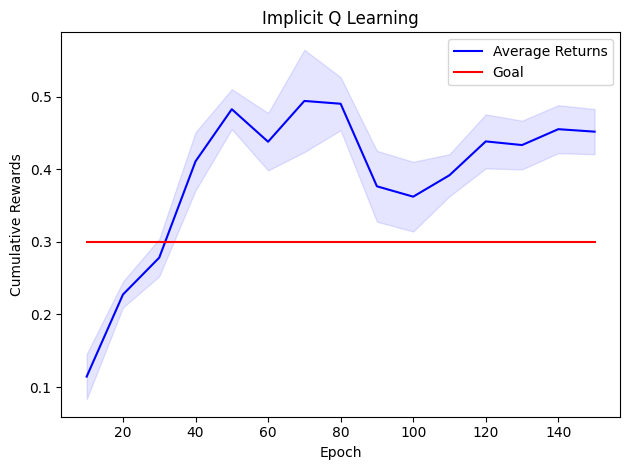

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [42]:
EPOCHS = 150
EVAL_FREQ = 10
LOAD_FROM_CKPT = False
alpha = 0.005 #for target network Polyak averaging

min_rew, max_rew = return_range(dataset, 1000) #for reward normalization. Returns min/max trajectory reward 


#############################################################################################

policy_lr_schedule = CosineAnnealingLR(policy_optimizer, EPOCHS * len(sampler)) #similarly to what is done in the paper

means, stds, start_epoch = [], [], 0
if os.path.exists('iql_checkpoint.pth') and LOAD_FROM_CKPT:
    checkpoint = torch.load('iql_checkpoint.pth')

    iql_policy.load_state_dict(checkpoint['iql_policy'])
    policy_optimizer.load_state_dict(checkpoint['policy_optimizer'])
    v_critic.load_state_dict(checkpoint['v_critic'])
    v_optimizer.load_state_dict(checkpoint['v_optimizer'])
    q_critic.load_state_dict(checkpoint['q_critic'])
    q_critic_target.load_state_dict(checkpoint['q_critic_target'])
    q_optimizer.load_state_dict(checkpoint['q_optimizer'])
    
    start_epoch = checkpoint['epoch']
    means = checkpoint['means']
    stds = checkpoint['stds']
    
    print(f'Resuming run from epoch {start_epoch}')

for epoch in range(start_epoch, EPOCHS):
    total_q_loss = total_v_loss = total_policy_loss = count = 0
    policy_losses = []
    # for batch in tqdm(dataloader):
    for batch in tqdm(sampler):
        state = batch['state'].to(DEVICE)
        next_state = batch['next_state'].to(DEVICE)
        action = batch['action'].to(DEVICE)
        reward = einops.rearrange(batch['reward'], 'b -> b 1').to(DEVICE)
        reward = reward / (max_rew - min_rew) * 1000
        #reward = reward-1
        not_done = einops.rearrange(batch['not_done'], 'b -> b 1').to(DEVICE)
        
        #Update V using expectile loss
        v_loss = expectile_loss(torch.minimum(*q_critic_target(state,action))-v_critic(state), expectile=tau).mean()
        v_optimizer.zero_grad()
        v_loss.backward()
        v_optimizer.step()
        
        #Update Q using TD targets, calculated using V function to avoid OOD actions
        target = reward+not_done*discount*v_critic(next_state)
        q_loss = Q_loss(target, q_critic)
        q_optimizer.zero_grad()
        q_loss.backward()
        q_optimizer.step()
        
        #Perform a soft target network update (Polyak averaging)
        for var, var_target in zip(q_critic.parameters(), q_critic_target.parameters()):
            var_target.data = alpha * var.data + (1.0 - alpha) * var_target.data
        
        #Update policy using advantage weighted regression
        policy_loss_ = policy_loss(iql_policy, q_critic_target, v_critic, state, action)
        policy_optimizer.zero_grad()
        policy_loss_.backward()
        policy_optimizer.step()

        policy_lr_schedule.step()
        
        #Record the losses throughout the training
        total_v_loss += v_loss.item()
        total_q_loss += q_loss.item()
        total_policy_loss += policy_loss_.item()
        count += 1
    
    #Evaluation step
    if (epoch + 1) % EVAL_FREQ == 0:
        rew_mean, rew_std = eval_policy(iql_policy, environment_name=ENVIRONMENT_NAME, eval_episodes=50)
        print(f'Epoch: {epoch + 1}. Q Loss: {total_q_loss / count:.4f}. V Loss: {total_v_loss / count:.4f}. P Loss: {total_policy_loss / count:.4f}. Reward: {rew_mean:.4f} +/- {rew_std:.4f}')
        means.append(rew_mean)
        stds.append(rew_std)

    # Save a checkpoint so that you can resume training if it crashes
    checkpoint = {
        'iql_policy': iql_policy.state_dict(),
        'policy_optimizer': policy_optimizer.state_dict(),
        'v_critic': v_critic.state_dict(),
        'v_optimizer': v_optimizer.state_dict(),
        'q_critic': q_critic.state_dict(),
        'q_critic_target': q_critic_target.state_dict(),
        'q_optimizer': q_optimizer.state_dict(),
        'epoch': epoch + 1,
        'means': means,
        'stds': stds
    }
    torch.save(checkpoint, 'iql_checkpoint.pth')

epochs = np.arange(EVAL_FREQ, EPOCHS+1, step=EVAL_FREQ)

plot_returns(means, stds, 'Implicit Q Learning', goal=0.3, epochs=epochs)

/scratch/1036318/ipykernel_3803889/1579723845.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  iql_policy.load_state_dict(torch.load('iql_checkpoint.pth')['iql_policy'])


3196.315473942263


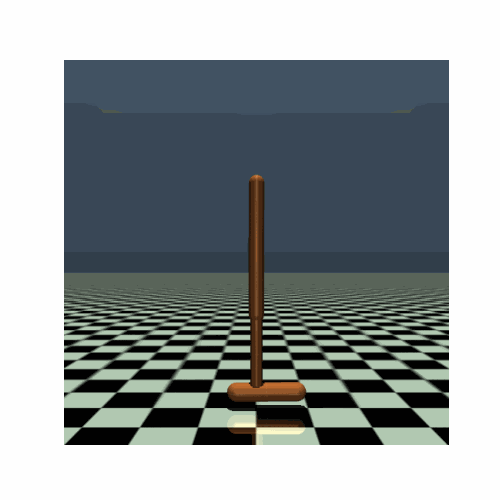

In [44]:
iql_policy.load_state_dict(torch.load('iql_checkpoint.pth')['iql_policy'])
frames, total_reward = demo_policy(iql_policy, environment_name=ENVIRONMENT_NAME, steps=1000)
print(total_reward)
gif_path = save_frames_as_gif(frames, method_name='iql')
Image(open(gif_path,'rb').read())